<h1>Saliency Prediction using DeepGaze IIE</h1>
<i>Gonzalo Muradás Odriozola</i>

Saliency refers to the attribute of the different elements of an image on which people's eyes focust first. In computer vision a saliency map assigns a value to every pixel of an image indicating how likely is that people focus on that area. [DeepGaze IIE](https://arxiv.org/abs/2105.12441) is a deep leatning model with a ResNet backbone that predicts just that. In this notebook the model will be used to predict the saliency maps of some experiment images. Model downloaded from [here](https://github.com/matthias-k/DeepGaze).

In [6]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from os import listdir
from scipy.ndimage import zoom
from scipy.special import logsumexp
from os.path import isfile, join, exists

import deepgaze_pytorch

<h3>Downloading model</h3>

The model will be downloaded in the next block, since it is only going to be used for predicting using the cpu is fine, although slower than using cuda.

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("USING:",DEVICE)

model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

USING: cuda
Loaded pretrained weights for efficientnet-b5


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to C:\Users\Gonzalo/.cache\torch\hub\v0.6.0.zip
c:\Users\Gonzalo\miniconda3\envs\torchEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\Gonzalo/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:16<00:00, 4.84MB/s]
Using cache found in C:\Users\Gonzalo/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\Gonzalo\miniconda3\envs\torchEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecate

<h3>Load image</h3>

Fixations tend to be in the center of an image, therefore the model uses a center bias to add weight to the center images of the pixels. The center bias used here has been downloaded from this [link](https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy). It is also possible to use a uniform centerbias by creating a numpy array of zeros `centerbias_template = np.zeros((1024, 1024))`.

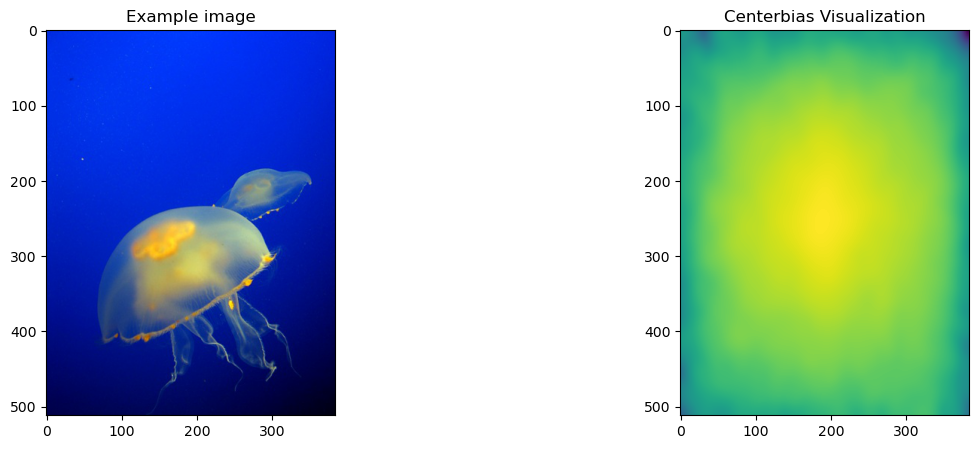

In [8]:
# Load example image
image = cv2.imread('images/images_nat/EVA - 5789.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Loading centerbias (1024x1024 pixels)
centerbias_template = np.load('centerBias/centerbias_mit1003.npy')
# Adjusting the centerbias to the image size (768x1024 pixels)
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# Renormalize log density
centerbias -= logsumexp(centerbias)

# Display 
fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].imshow(image), ax[0].set_title('Example image')
ax[1].imshow(centerbias), ax[1].set_title('Centerbias Visualization')
plt.show()

<h3>Prediction</h3>

Next, the model will be used to predict the single image, a 512x512 image should take around 5 seconds to predict using the cpu.

In [9]:
image_tensor = torch.tensor(np.array([image.transpose(2, 0, 1)])).to(DEVICE)
centerbias_tensor = torch.tensor(np.array([centerbias])).to(DEVICE)
log_density_prediction = model(image_tensor, centerbias_tensor)

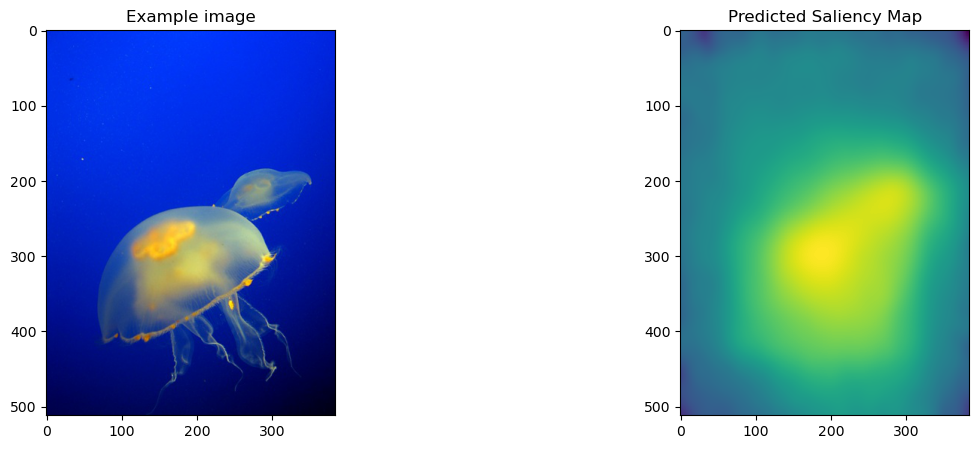

In [12]:
#Predicting
saliency_map = log_density_prediction.detach().cpu().numpy()[0][0]

# Display 
fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].imshow(image), ax[0].set_title('Example image')
ax[1].imshow(saliency_map), ax[1].set_title('Predicted Saliency Map')
plt.show()

<h3>Visualizing Saliency Heatmap</h3>

Next the saliency map is visualized as a heatmap in the image.

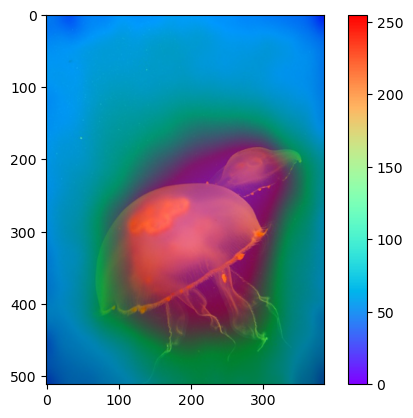

In [13]:
# Normalizing and transforming saliency map to heatmap
normalized = cv2.normalize(saliency_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
blur = cv2.GaussianBlur(normalized,(15,15), 11)
heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_RAINBOW)
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, image, 0.5, 0)

# Display
plt.imshow(super_imposed_img, cmap='rainbow')
colorbar = plt.colorbar()
plt.show()

<h3>Function to perform multiple predictions</h3>

Next all the code will be joined in one single function that takes as input a list of images and saves all masks and heatmaps to the specified path

In [15]:
IMAGES_PATH = 'images'
OUTPUT_PATH = 'output'

# Getting all filenames
artImages = [f for f in listdir(join(IMAGES_PATH,'images_art')) if isfile(join(IMAGES_PATH,'images_art',f))]
natImages = [f for f in listdir(join(IMAGES_PATH,'images_nat')) if isfile(join(IMAGES_PATH,'images_nat',f))]
allImages = artImages + natImages

# Returns the correct path for the image
def getImgPath(imgName):
    if exists(join('images/images_art',imgName)):
        return join('images/images_art',imgName)
    elif exists(join('images/images_nat', imgName)):
        return join('images/images_nat',imgName)
    else:
        return "error" 

# Saves all predicted saliency maps w
def getSaliencyHeatmaps(images, outputPath):
    # Downloading model
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("USING:",DEVICE)
    model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

    # Loading images
    centerbias_template = np.load('centerBias/centerbias_mit1003.npy')
    for image in tqdm(images, total = len(images)):
        # Loading image
        img = cv2.imread(getImgPath(image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Centerbias
        centerbias = zoom(centerbias_template, (img.shape[0]/centerbias_template.shape[0], img.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        centerbias -= logsumexp(centerbias)
        # Predict
        image_tensor = torch.tensor(np.array([img.transpose(2, 0, 1)])).to(DEVICE)
        centerbias_tensor = torch.tensor(np.array([centerbias])).to(DEVICE)
        log_density_prediction = model(image_tensor, centerbias_tensor)
        saliency_map = log_density_prediction.detach().cpu().numpy()[0][0]
        # Transform
        normalized = cv2.normalize(saliency_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        blur = cv2.GaussianBlur(normalized,(15,15), 11)
        heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_RAINBOW)
        super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)

        cv2.imwrite(join(outputPath, f'heatmap_{image}'),super_imposed_img)
        cv2.imwrite(join(outputPath, f'mask_{image}'),normalized)

getSaliencyHeatmaps(allImages, OUTPUT_PATH)

USING: cuda


c:\Users\Gonzalo\miniconda3\envs\torchEnv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gonzalo\miniconda3\envs\torchEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\Gonzalo/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\Gonzalo\miniconda3\envs\torchEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\Gonzalo/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\Gonzalo\miniconda3\envs\torchEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
 